<a href="https://colab.research.google.com/github/darkxaze/Machinelearnning-courseworkprojects/blob/main/PneumoniaMNISTDNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Medical Image Analysis 
A simple deeply connected neural network model trained using a simple pathology image dataset.The dataset used is <bold>PneumoniaMNIST

To use GPU acceleration make sure to change your runtime type in Google Colab to GPU.

## Python Imports
This section will load the necessary python packages to the instance.

In [45]:
# Built-in Imports
import random

In [46]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [47]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader
This section will download the selected [MedMNIST](https://medmnist.github.io/) dataset as a NumPy array object to your Google Colab instance. 

To change the dataset that will download just change the variable DATA_NAME to desired dataset name.

All storage on a Google Colab instance is deleted when the instance ends so the dataset will need to be redownloaded each time an instance is created (Don't worry this usually takes about 20 seconds).

The dataset used in the current model is called PneumoniaMNIST. All images are Greyscale. The images are standardized and the height x width is 28x28 size

In [48]:
DATA_NAME = "PneumoniaMNIST"

In [49]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2022-04-08 18:47:39--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22843 (22K) [text/plain]
Saving to: ‘info.py.2’

info.py.2           100%[===================>]  22.31K  --.-KB/s    in 0.002s  

2022-04-08 18:47:39 (13.6 MB/s) - ‘info.py.2’ saved [22843/22843]



In [50]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz", 
                     origin=data["url"], 
                     md5_hash=data["MD5"])

In [51]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object, Normalize and convert it to rgb 3channel image.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]
train_x = train_x.astype('float32') / 255
train_x =np.repeat(train_x[..., np.newaxis], 3, -1)
# Gets the validation images and labels from the NumPy object, Normalize and convert it to rgb 3channel image.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]
val_x = val_x.astype('float32') / 255
val_x =np.repeat(val_x[..., np.newaxis], 3, -1)
# Gets the testing images and labels from the NumPy object, Normalize and convert it to rgb 3channel image.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]
test_x = test_x.astype('float32') / 255
test_x =np.repeat(test_x[..., np.newaxis], 3, -1)


## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [52]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]
targetnames=list(data["label"].values())
# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]), 
                            np.append(val_counts, [sum(val_counts)]), 
                            np.append(test_counts, [sum(test_counts)]))), 
                   index=labels, columns=["Train", "Val", "Test"]))

           Train  Val  Test
normal      1214  135   234
pneumonia   3494  389   390
total       4708  524   624


823: pneumonia


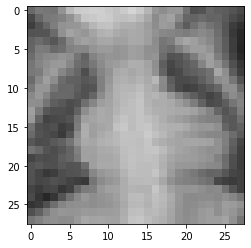

In [53]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

## Data Processing
In this section we will create a data loader for algorithm that will dynamiclly load and augment the data when needed.

Data processing is applied to the dataset to auguement data when the size of the data set is small. The advantages of data augmentation are as follows:

  

*   It reduces the cost of collection of data.
*   It reduces data overfitting.
*   It creates variability and flexibility in data models.



In the model applied we implement horizontal flipping,vertical flipping, 
featurewise Pixel Normalization: scale pixel values to the range 0-1.
featurewise Pixel Centering: scale pixel values to have a zero mean.

featurewise here means per dataset

The fit function is then invoked to calculate the image statistics in the data generator function and store the value in memory
    


In [54]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True, 
                                    vertical_flip=True)

In [55]:
data_generator.fit(np.append(train_x, val_x, 0))

## Model Definition
In this section we will define the neural network arcitecture.
The model choose for this exercise is a densely connected neural network. We inirailize the input layer by flatterning the 3 channel image to input all the features. Then we create a dense hidden network with 5 neurons and activation function Relu. Finally we create the output layer with activation function sigmoid to classify binary labels. The model was created in such way to equate the number of parameters in the previous exercise. 

In [36]:
from keras import models
from keras import layers

model = models.Sequential([layers.Flatten(input_shape = train_x[0].shape),
layers.Dense(5, activation = 'relu' ),
layers.Dense(len(np.unique(train_y)), activation = 'sigmoid' )])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2352)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 11765     
                                                                 
 dense_3 (Dense)             (None, 2)                 12        
                                                                 
Total params: 11,777
Trainable params: 11,777
Non-trainable params: 0
_________________________________________________________________


## Model Training
This is where we define the training options and then train the model.



*   Stochastic gradient descent is an iterative learning algorithm that uses a training dataset to update a model.

*   The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.
*   The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.

*   learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.


*  Loss functions measure how far an estimated value is from its true value
binary crossentropy is a loss function that is used in binary-class classification tasks. It is used to classify when examples only belong to one out of many possible categories.
*   Metrics are used to evaluate the model. Accuracy Calculates how often predictions equal labels. 

*   Shuffle is set to false so that no shuffling of data takes places when augumenting data to preserve index









In [37]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [38]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 2352)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 11765     
                                                                 
 dense_3 (Dense)             (None, 2)                 12        
                                                                 
Total params: 11,777
Trainable params: 11,777
Non-trainable params: 0
_________________________________________________________________


In [40]:
# We use the data generator to pass the training and validation data to the model to train it.
history = model.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE,shuffle=False), 
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE,shuffle=False),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)
#history = model.fit(train_x, to_categorical(train_y),batch_size = BATCH_SIZE,steps_per_epoch=len(train_x) / BATCH_SIZE,validation_data = (val_x, to_categorical(val_y)),epochs=NUM_EPOCHS,validation_steps=len(val_x) / BATCH_SIZE)

Epoch 1/10
73/73 [==============================] - 1s 12ms/step - loss: 0.6634 - accuracy: 0.6519 - val_loss: 0.5905 - val_accuracy: 0.7729
Epoch 2/10
73/73 [==============================] - 1s 9ms/step - loss: 0.5497 - accuracy: 0.8050 - val_loss: 0.5112 - val_accuracy: 0.8416
Epoch 3/10
73/73 [==============================] - 1s 9ms/step - loss: 0.4898 - accuracy: 0.8398 - val_loss: 0.4708 - val_accuracy: 0.8435
Epoch 4/10
73/73 [==============================] - 1s 9ms/step - loss: 0.4334 - accuracy: 0.8666 - val_loss: 0.4197 - val_accuracy: 0.8721
Epoch 5/10
73/73 [==============================] - 1s 10ms/step - loss: 0.3901 - accuracy: 0.8798 - val_loss: 0.3734 - val_accuracy: 0.8950
Epoch 6/10
73/73 [==============================] - 1s 11ms/step - loss: 0.3559 - accuracy: 0.8849 - val_loss: 0.3504 - val_accuracy: 0.8893
Epoch 7/10
73/73 [==============================] - 1s 9ms/step - loss: 0.3371 - accuracy: 0.8889 - val_loss: 0.3170 - val_accuracy: 0.9122
Epoch 8/10
73/73 

## Plot Learning Curves
This is where we visualise the training of the model.

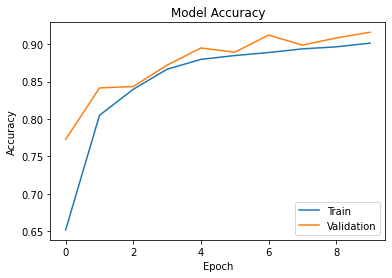

In [41]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

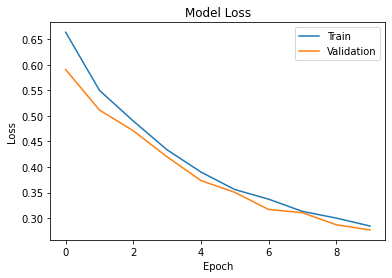

In [42]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Evaluate Data
We evaulate data using the model.evaluate function and passing the test data and the corresponding test labels. we use the model train to predict values based on test data and compare it to test lables to predict accuracy.

In [43]:
model.evaluate(data_generator.flow(test_x, to_categorical(test_y),batch_size=BATCH_SIZE,shuffle=False))


10/10 [==============================] - 0s 7ms/step - loss: 0.4492 - accuracy: 0.8109


[0.4492439925670624, 0.8108974099159241]

In [44]:
# predict values using the augumented test data set
ypred=model.predict(data_generator.flow(test_x,batch_size=BATCH_SIZE,shuffle=False))
# convert probability distribution to index of the class
ypred1 = np.argmax(ypred, 1)
# convert to categorical
testy1=to_categorical(test_y,num_classes=2)
# identify the index of the class
testy2= np.argmax(testy1, 1)
print(classification_report(testy2, ypred1,target_names=targetnames))

              precision    recall  f1-score   support

      normal       0.87      0.60      0.71       234
   pneumonia       0.80      0.95      0.87       390

    accuracy                           0.82       624
   macro avg       0.83      0.77      0.79       624
weighted avg       0.83      0.82      0.81       624



# Inference

In this exercise we classify an Binary-class(2) dataset with a densely connected neural network. our model consist of an input layer which takes 28x28x3 as input , a densely connected hidden layerwith 5 neurons finally an output layer with 2 neurons. The total number of trainable parameters is 16552. The proposed model has an accuracy of 82%  with the augumented test dataset. This in line with the predicted values in the classification report. The testdataset is augumented because we need the test set to be similar to the training set due to image processing like standardization,centering,cropping etc. The reason for this is expected to be unbalanced dataset.

F1 score is a combined metric defined as product of precision*recall over the sum of precision and recall. Precision is defined as true positive over sum of true positive and false positive, Recall is definied as the true positive over sum of true positive and false negative. Precision can be seen as a measure of quality, and recall as a measure of quantity. Higher precision means that an algorithm returns more relevant results than irrelevant ones, and high recall means that an algorithm returns most of the relevant results. Our ideal value is getting a 1 on F1 score meaning 1 on both precision as well as recall.
From the classification report we can see that normal has a f1 score of 0.71 compared to 0.01 meaning less error during classification. This can be attributed to the unbalanced nature of the dataset, with pneumonia having twice as much as normal in training and validation which can lead to a biased CNN classifier and a low score in accuracy. This unbalanced data can be avoided my undersampling majority class or oversampling the minority class. Another issue is the CNN network may have been caught in local minima due to the unbalanced data sets. 